The Goal: figure out if tire compound is predictive and if we can format the signal in a way that feeds into a simple mode. See if there is a pattern with tire compounds. Format the tire compounds so that it can be used with a simple model. 

In [ ]:
#Import dependencies
import fastf1
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import fastf1.plotting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

Loading the 2024 Bahrain Session in fastf1. This will be our default session.

In [98]:
fastf1.plotting.setup_mpl(color_scheme='fastf1')
session = fastf1.get_session(2024, 'Bahrain', 'R')
session.load()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Hamilton's Tire Compound vs. Lap Time in the 2024 Bahrain Race. 

/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3283310820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_time_sec = ham_laps['LapTimeSec'] = ham_laps['LapTime'].dt.total_seconds()


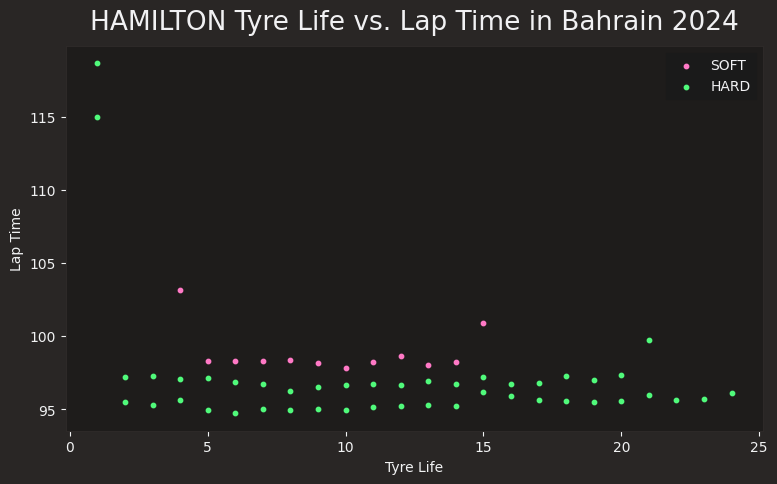

In [99]:
ham_laps = session.laps.pick_drivers('HAM')
lap_time_sec = ham_laps['LapTimeSec'] = ham_laps['LapTime'].dt.total_seconds()
tyre_life = ham_laps['TyreLife']

lap_time = ham_laps['LapTime']

compounds = ham_laps['Compound'].dropna().unique() if 'Compound' in ham_laps.columns else []

fig, ax = plt.subplots(figsize=(9, 5))

if len(compounds):
    for c in compounds:
        df = ham_laps[ham_laps['Compound'] == c]
        ax.scatter(df['TyreLife'], df['LapTimeSec'], s=10, label=str(c))
else:
    ax.scatter(ham_laps['TyreLife'], ham_laps['LapTimeSec'], s=10)
    
# The rest is just plotting
# fig, ax = plt.subplots()
# ax.plot(seconds, tyre_life, label='TyreLife')
ax.set_xlabel('Tyre Life')
ax.set_ylabel('Lap Time')
ax.set_title('HAMILTON Tyre Life vs. Lap Time in Bahrain 2024')
ax.legend()
plt.show()

Now we look at Every Driver Tire Compound vs. Lap Time in the 2024 Bahrain Race.

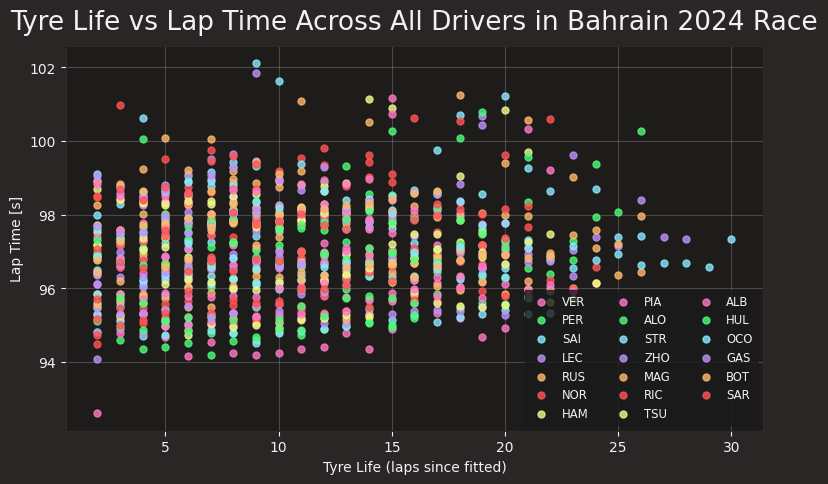

In [100]:
drivers = session.drivers
fig, ax = plt.subplots(figsize=(9, 5))

for drv in drivers:
    driver_info = session.get_driver(drv)
    name = driver_info.Abbreviation  # or driver_info.FullName
    
    dlaps = session.laps.pick_drivers(drv).pick_quicklaps().copy()
    dlaps['LapTimeSec'] = dlaps['LapTime'].dt.total_seconds()
    dlaps['TyreLifeComputed'] = (
        dlaps['TyreLife'] if 'TyreLife' in dlaps.columns and dlaps['TyreLife'].notna().any()
        else dlaps.groupby('Stint').cumcount() + 1
    )
    
    ax.scatter(
        dlaps['TyreLifeComputed'], 
        dlaps['LapTimeSec'], 
        s=25, 
        label=name, 
        alpha=0.8
    )

ax.set_xlabel('Tyre Life (laps since fitted)')
ax.set_ylabel('Lap Time [s]')
ax.set_title('Tyre Life vs Lap Time Across All Drivers in Bahrain 2024 Race')
ax.legend(ncol=3, fontsize='small')
ax.grid(True, alpha=0.3)
plt.show()


Every Driver Tire Compound vs. Lap time across all races in the 2024 season. 

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix

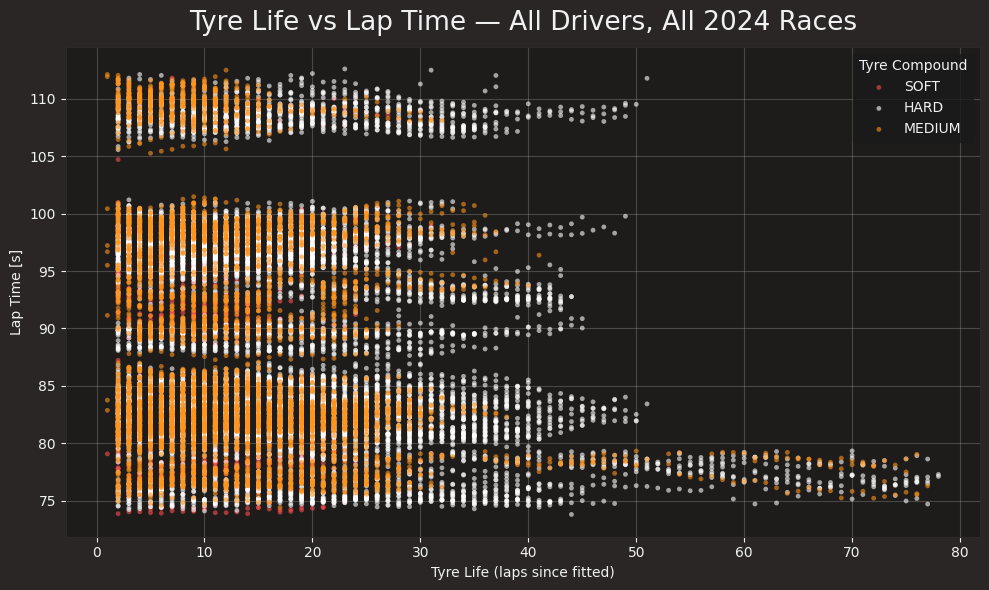

In [101]:
schedule = fastf1.get_event_schedule(2024)
# Keep only proper Grands Prix (exclude tests/sprints if desired)
schedule = schedule[schedule['EventFormat'].isin(['conventional', 'sprint'])]
# We'll still take the main Race ('R') session for both formats.

all_laps_list = []

for _, row in schedule.iterrows():
    event_name = row['EventName']    # e.g., 'Bahrain Grand Prix'
    year = int(row['EventDate'].year)

    try:
        session = fastf1.get_session(year, event_name, 'R')
        session.load()  # may use cached data if available

        laps = session.laps
        if laps is None or laps.empty:
            continue

        # Keep reasonable laps (drops pit-in/out, very slow, SC/VSC laps)
        laps = laps.pick_quicklaps().copy()

        # Lap time in seconds
        laps['LapTimeSec'] = laps['LapTime'].dt.total_seconds()

        # Tyre life: use provided if available, else compute per driver+stint
        if 'TyreLife' in laps.columns and laps['TyreLife'].notna().any():
            laps['TyreLifeComputed'] = laps['TyreLife']
        else:
            laps['TyreLifeComputed'] = laps.groupby(['Driver', 'Stint']).cumcount() + 1

        # Keep only columns we need; add event for reference if you want
        keep_cols = ['Compound', 'LapTimeSec', 'TyreLifeComputed']
        laps = laps[keep_cols].dropna(subset=['Compound', 'LapTimeSec', 'TyreLifeComputed'])

        all_laps_list.append(laps)

    except Exception as e:
        # If a session fails to load, just skip it
        print(f"Skipping {event_name}: {e}")

# Concatenate all races
if not all_laps_list:
    raise RuntimeError("No lap data was collected for 2024 races.")
all_laps = pd.concat(all_laps_list, ignore_index=True)

# --- Plot: Tyre Life vs Lap Time, colored by Compound ---
# Standard F1 colors (with safe fallbacks)
compound_colors = {
    'SOFT':   '#ff4d4d',   # red
    'MEDIUM': "#ff941a",   # yellow
    'HARD':   "#ffffff",   # white
    'INTERMEDIATE': '#39d353',  # green (rare in races)
    'WET':    '#2f6fff'    # blue (rare in races)
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each compound separately so legend only shows compounds (no drivers)
compounds_present = all_laps['Compound'].dropna().unique()
for comp in compounds_present:
    df = all_laps[all_laps['Compound'] == comp]
    color = compound_colors.get(comp, 'gray')
    ax.scatter(
        df['TyreLifeComputed'],
        df['LapTimeSec'],
        s=12,
        alpha=0.6,
        c=color,
        edgecolors='none',
        label=comp
    )

ax.set_xlabel('Tyre Life (laps since fitted)')
ax.set_ylabel('Lap Time [s]')
ax.set_title('Tyre Life vs Lap Time — All Drivers, All 2024 Races')
ax.legend(title='Tyre Compound')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [103]:
data = all_laps[['LapTimeSec', 'TyreLifeComputed', 'Compound']].dropna()

# Encode compounds (target)
le = LabelEncoder()
data['CompoundEncoded'] = le.fit_transform(data['Compound'])

# Features (X) and target (y)
X = data[['LapTimeSec', 'TyreLifeComputed']]
y = data['CompoundEncoded']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression classifier
model = LogisticRegression(max_iter=200)
model.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred = model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

        HARD       0.60      0.99      0.75      1889
      MEDIUM       0.33      0.01      0.02      1001
        SOFT       0.00      0.00      0.00       268

    accuracy                           0.60      3158
   macro avg       0.31      0.33      0.26      3158
weighted avg       0.46      0.60      0.45      3158



/Users/mihir/StudioProjects/Python/Jupyter/F1ML2/F1ML2/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mihir/StudioProjects/Python/Jupyter/F1ML2/F1ML2/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mihir/StudioProjects/Python/Jupyter/F1ML2/F1ML2/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

We just used a model to predict compounds. This is the confusion matrix of the predictions.

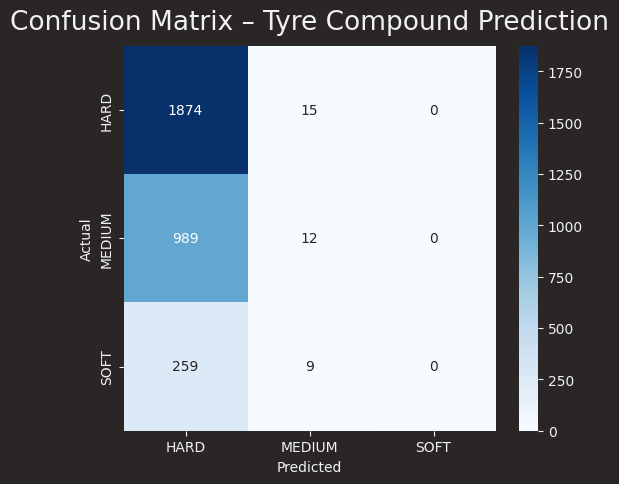

In [104]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Tyre Compound Prediction')
plt.show()


Now we are going to do the opposite. We are going to through to predict the Lap Time given data on the Tyre Compound and the Tyre Life. 
We are going to do the same thing we did with the above, except have the x-axis be the Tyre Compound, and Y-axis be the Tyre Life. And the labels are the speeds.  

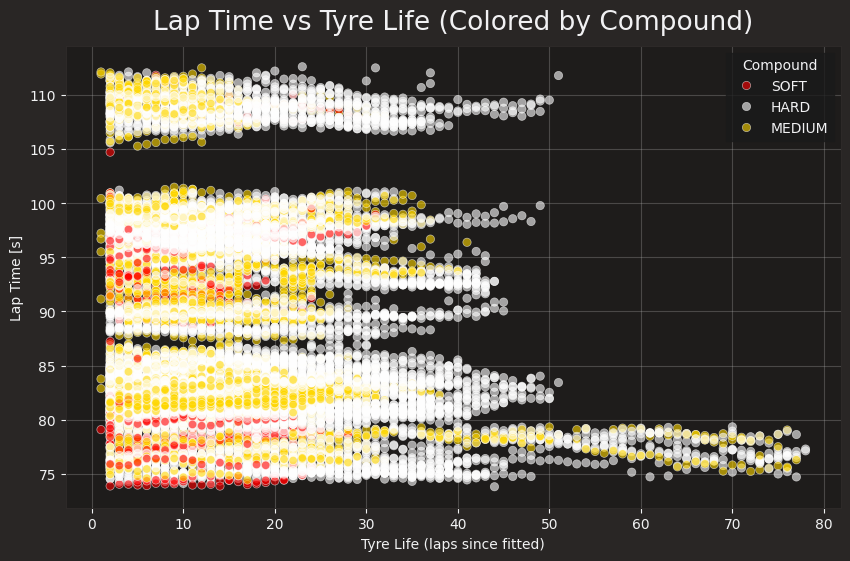

In [105]:
data = all_laps[['LapTimeSec', 'TyreLifeComputed', 'Compound']].dropna()

le = LabelEncoder()
data['CompoundEncoded'] = le.fit_transform(data['Compound'])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x='TyreLifeComputed',
    y='LapTimeSec',
    hue='Compound',
    palette={'SOFT': 'red', 'MEDIUM': 'gold', 'HARD': 'white'},
    alpha=0.6
)
plt.xlabel('Tyre Life (laps since fitted)')
plt.ylabel('Lap Time [s]')
plt.title('Lap Time vs Tyre Life (Colored by Compound)')
plt.legend(title='Compound')
plt.grid(alpha=0.3)
plt.show()


Predict the laptime given the Tyre Life and the Tyre Compound

In [106]:
# Features (X) and target (y)
X = data[['TyreLifeComputed', 'CompoundEncoded']]
y = data['LapTimeSec']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear regression
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Predict lap times
y_pred = reg.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")


Mean Absolute Error: 8.403
Root Mean Squared Error: 9.747


Graph of the Prediction

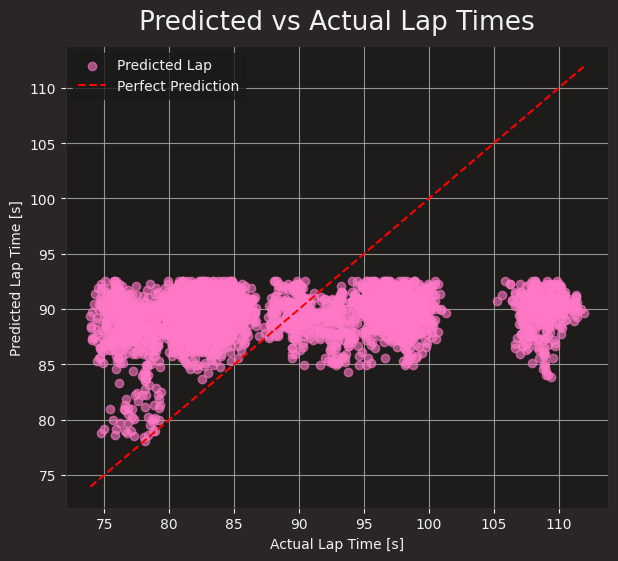

In [107]:
plt.figure(figsize=(7, 6))

plt.scatter(y_test, y_pred, alpha=0.6,label = "Predicted Lap")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Lap Time [s]')
plt.ylabel('Predicted Lap Time [s]')
plt.title('Predicted vs Actual Lap Times')
plt.legend()
plt.grid(True, alpha=0.8)
plt.show()




So we realized that training on all the races might not be ideal: so now we will train the model on each race, and output the confusion matrix. 


In [108]:
#
# Remember that session is the 2024 Bahrain Race (across all drivers)
laps = session.laps

laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()

laps['TyreLifeComputed'] = (
        laps['TyreLife'] if 'TyreLife' in laps.columns and laps['TyreLife'].notna().any()
        else laps.groupby('Stint').cumcount() + 1
    )

data = laps[['LapTimeSec', 'TyreLifeComputed', 'Compound']].dropna()

le = LabelEncoder()
data['CompoundEncoded'] = le.fit_transform(data['Compound'])


X = data[['TyreLifeComputed', 'CompoundEncoded']]
y = data['LapTimeSec']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear regression
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)

# Predict lap times
y_pred = reg.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")


Mean Absolute Error: 2.977
Root Mean Squared Error: 5.073


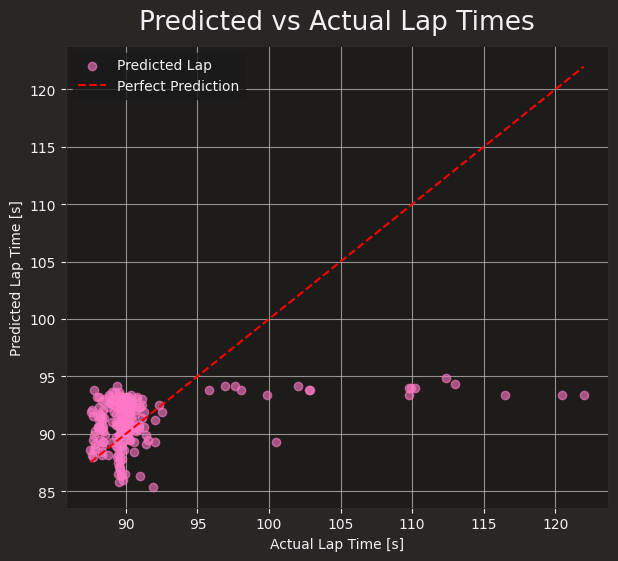

In [109]:
plt.figure(figsize=(7, 6))

plt.scatter(y_test, y_pred, alpha=0.6,label = "Predicted Lap")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel('Actual Lap Time [s]')
plt.ylabel('Predicted Lap Time [s]')
plt.title('Predicted vs Actual Lap Times in Bahrain')
plt.legend()
plt.grid(True, alpha=0.8)
plt.show()


Now we are going to run and check for several different races. We also only include laps that are "quick laps" so we do not include outliers

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Mean Absolute Error: 0.928
Root Mean Squared Error: 1.117


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


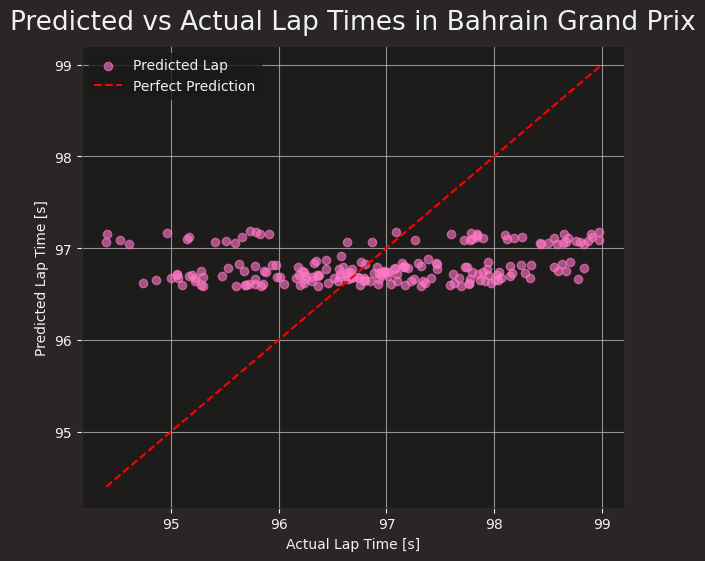

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


Mean Absolute Error: 0.984
Root Mean Squared Error: 1.200


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


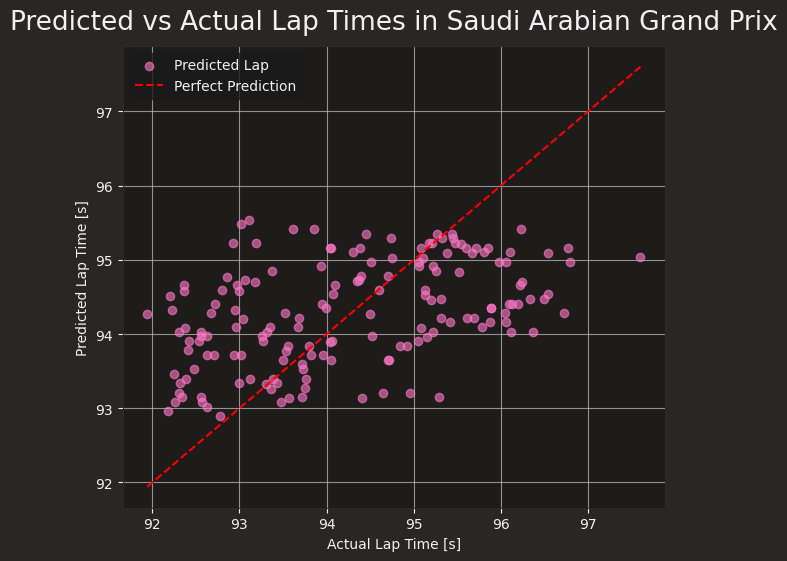

core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']


Mean Absolute Error: 0.831
Root Mean Squared Error: 0.998


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


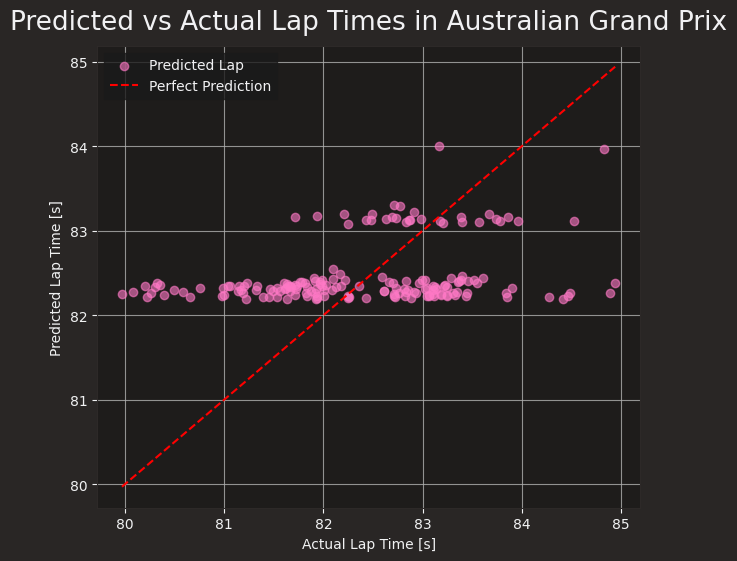

core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


Mean Absolute Error: 1.257
Root Mean Squared Error: 1.508


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


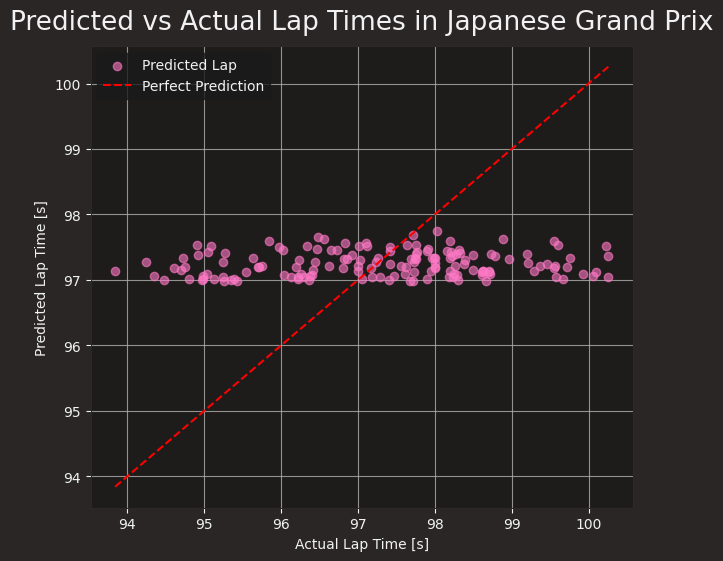

core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']


Mean Absolute Error: 0.820
Root Mean Squared Error: 0.978


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


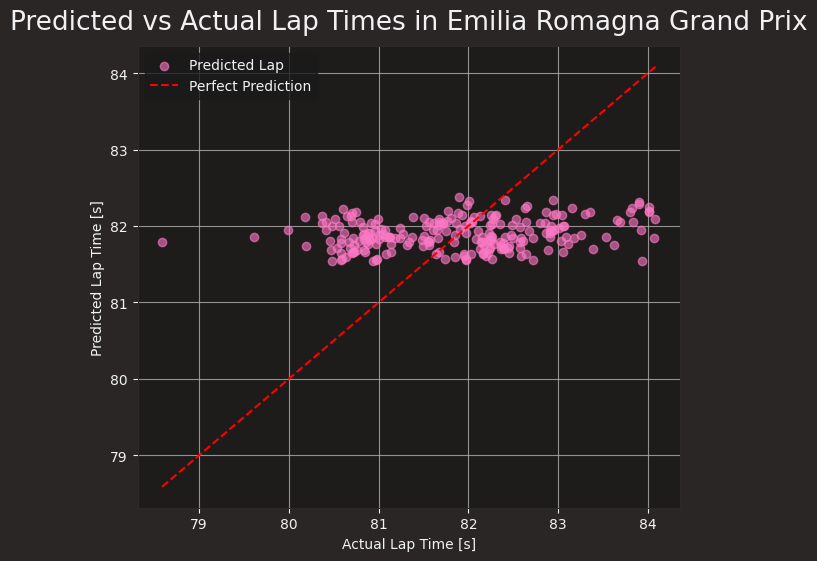

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


Mean Absolute Error: 1.036
Root Mean Squared Error: 1.179


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


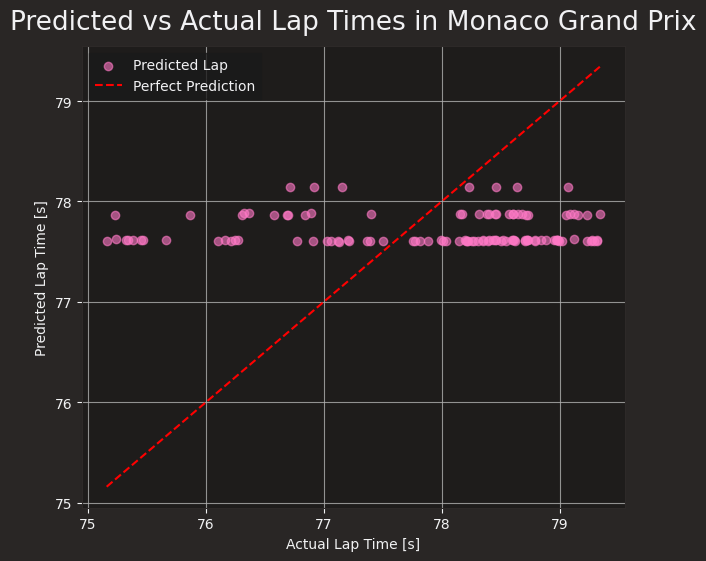

core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52

Mean Absolute Error: 1.052
Root Mean Squared Error: 1.247


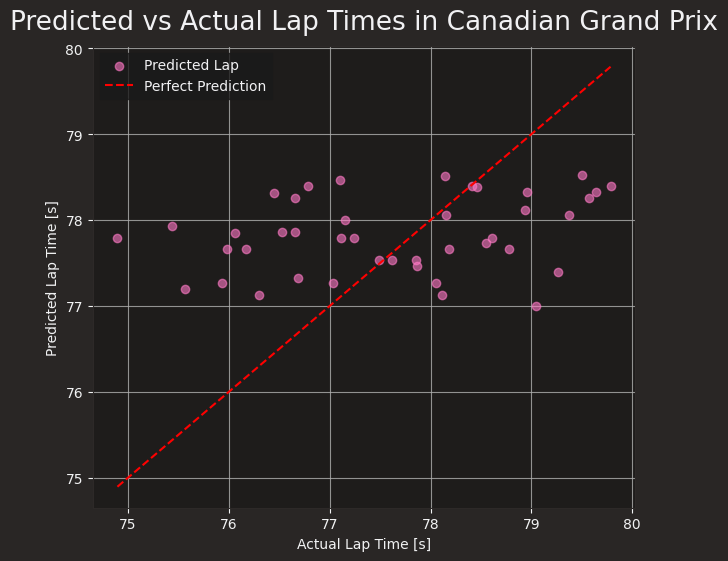

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14

Mean Absolute Error: 0.941
Root Mean Squared Error: 1.142


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


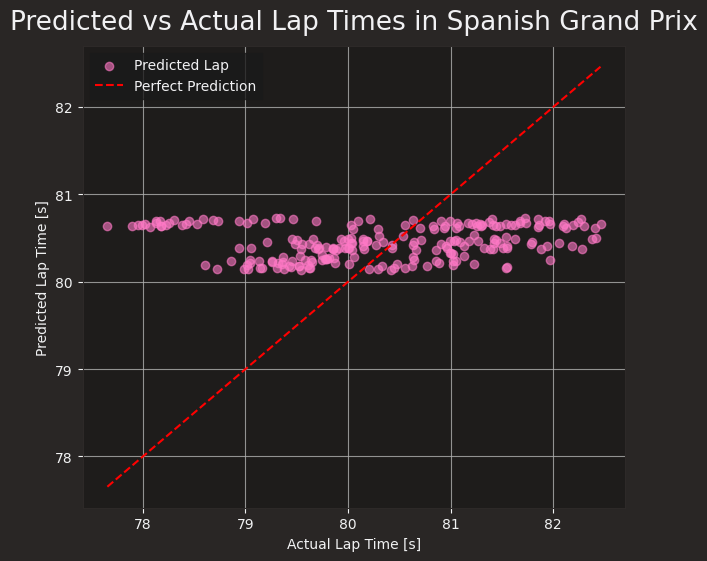

core           INFO 	Loading data for British Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


Mean Absolute Error: 1.050
Root Mean Squared Error: 1.286


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


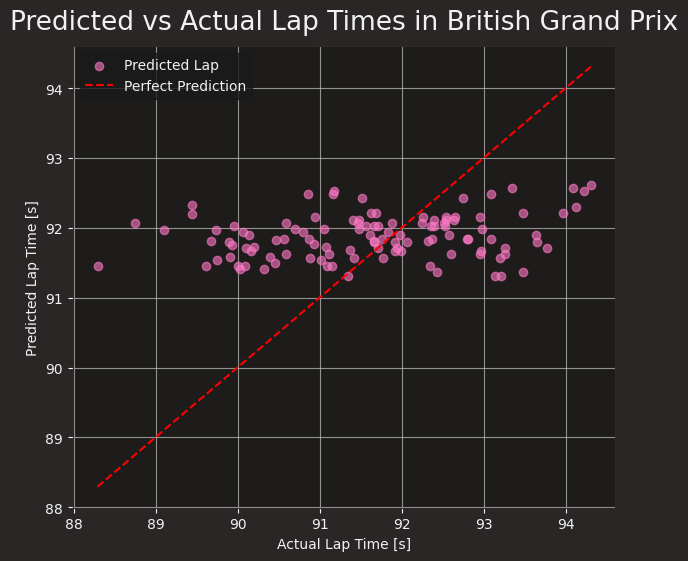

core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']


Mean Absolute Error: 0.881
Root Mean Squared Error: 1.040


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


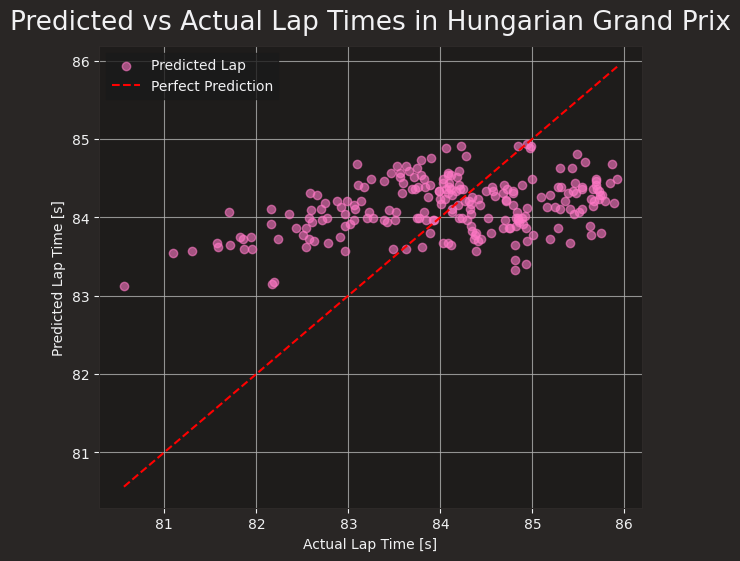

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '14'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data


Mean Absolute Error: 0.918
Root Mean Squared Error: 1.171


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


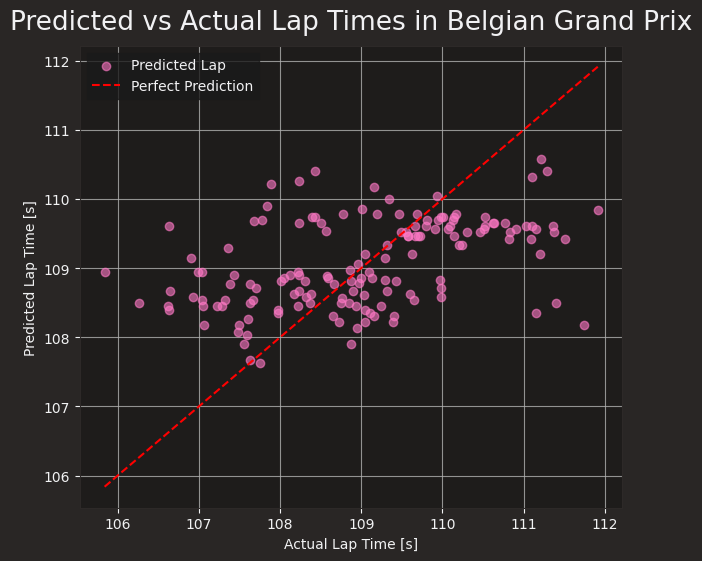

core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']


Mean Absolute Error: 0.775
Root Mean Squared Error: 1.017


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


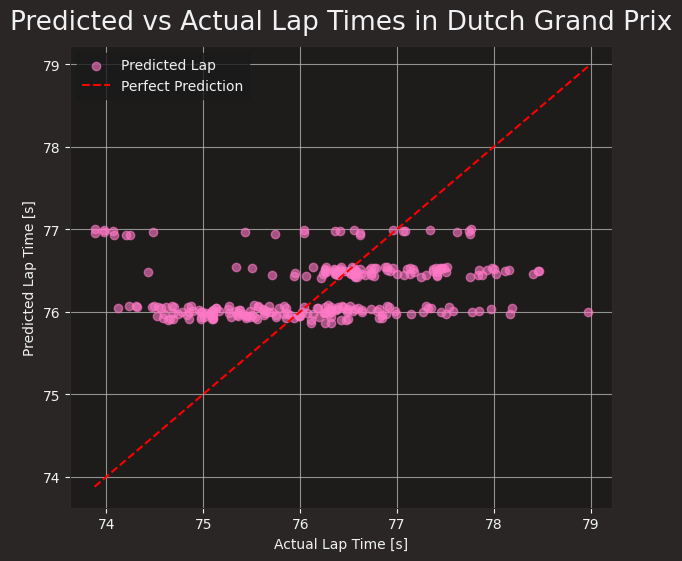

core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


Mean Absolute Error: 0.992
Root Mean Squared Error: 1.188


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


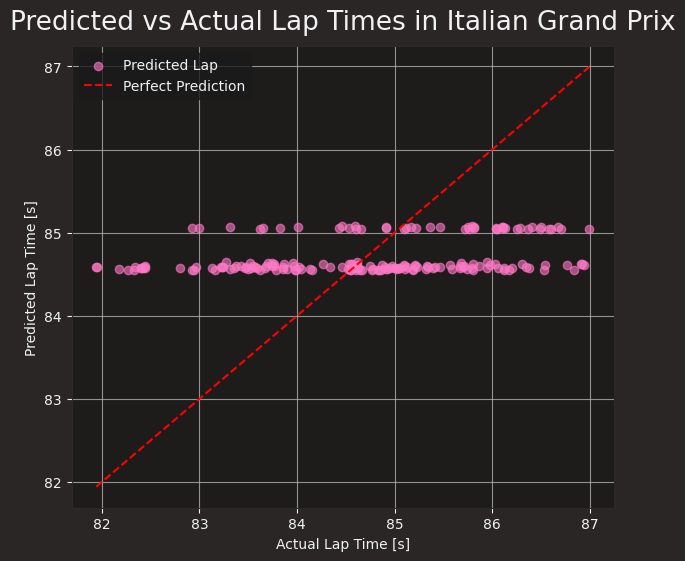

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


Mean Absolute Error: 0.924
Root Mean Squared Error: 1.163


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


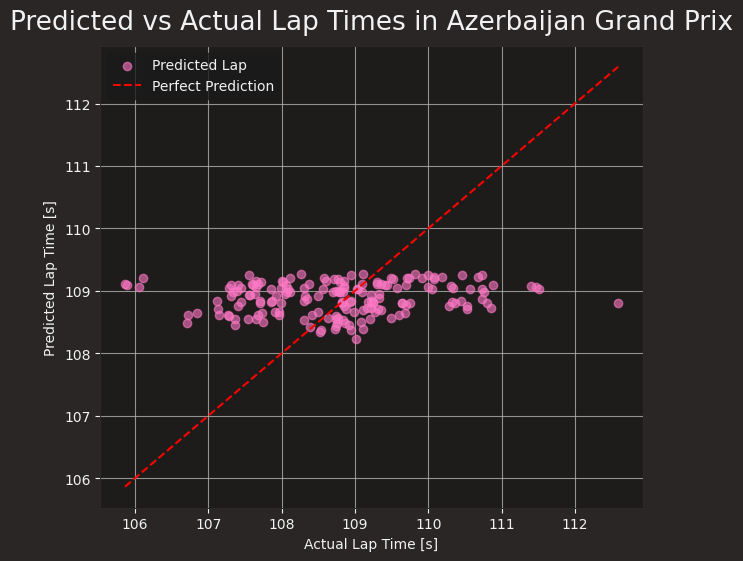

core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']


Mean Absolute Error: 0.907
Root Mean Squared Error: 1.117


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


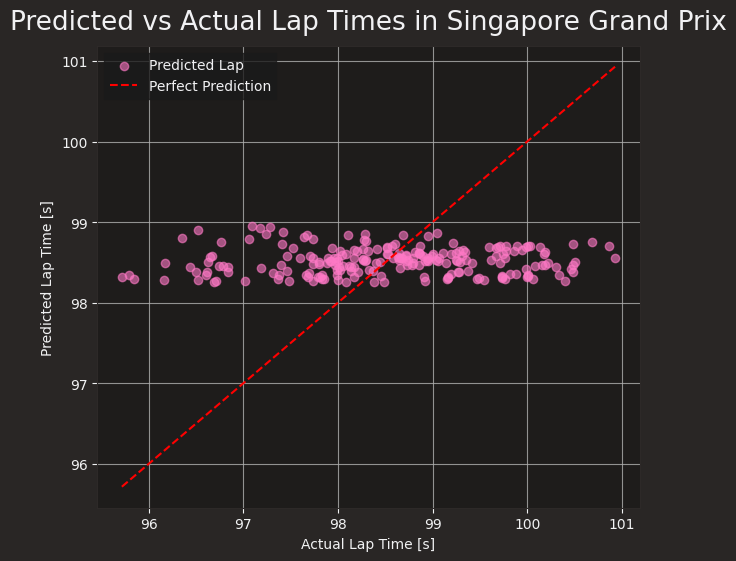

core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']


Mean Absolute Error: 0.831
Root Mean Squared Error: 0.963


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


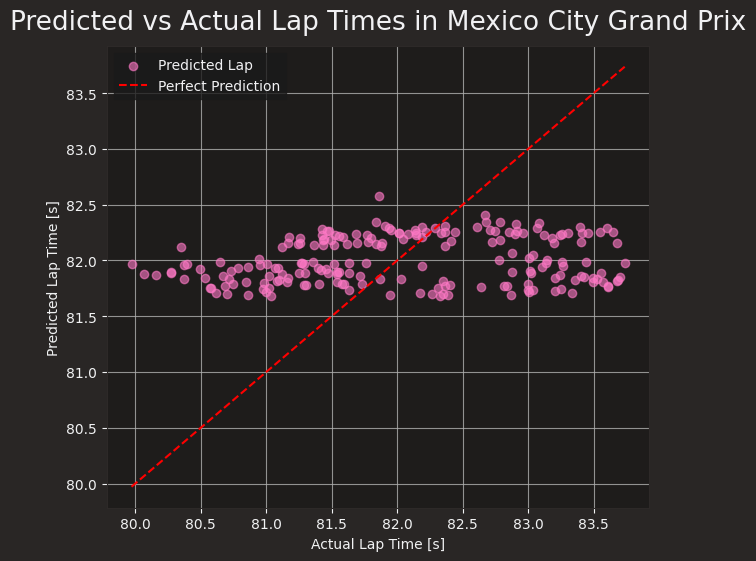

core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1

Mean Absolute Error: 0.930
Root Mean Squared Error: 1.130


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


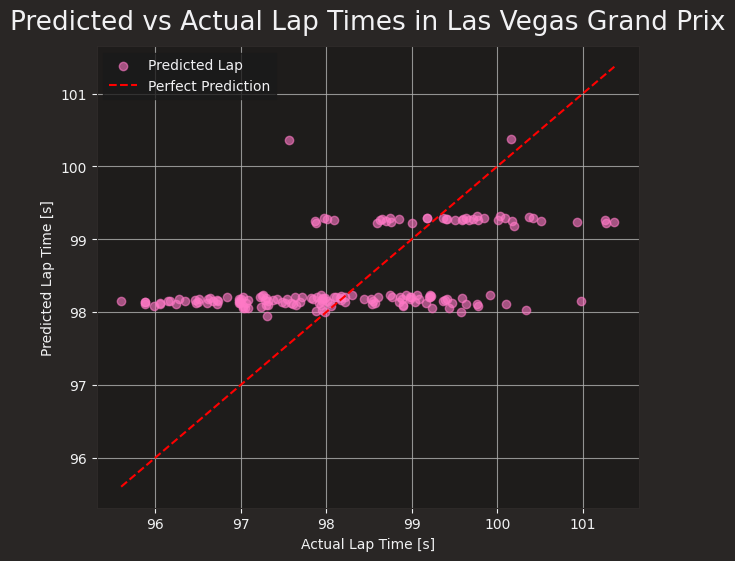

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']


Mean Absolute Error: 0.751
Root Mean Squared Error: 0.914


/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()
/var/folders/d1/3k9zww1d06q6_k5vh91cvksh0000gp/T/ipykernel_52480/3953890362.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['TyreLifeComputed'] = (


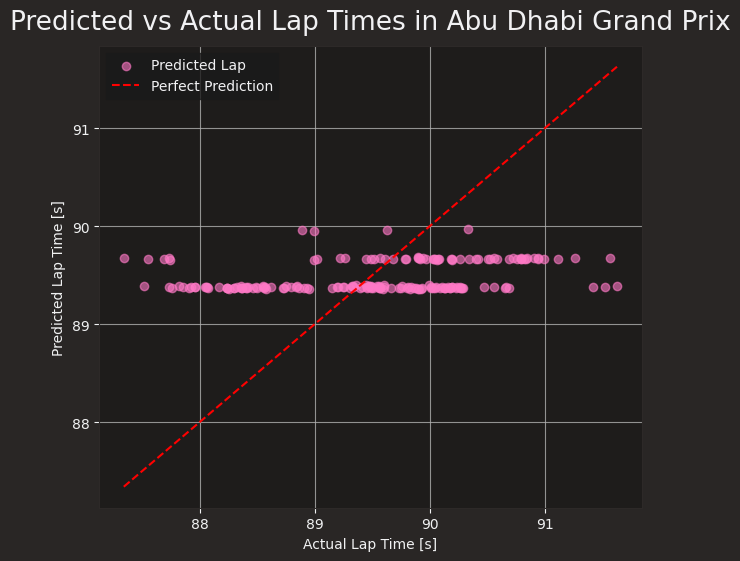

In [110]:
#WE Run across all races
schedule = fastf1.get_event_schedule(2024)
# Keep only proper Grands Prix (exclude tests/sprints if desired)
schedule = schedule[schedule['EventFormat'].isin(['conventional', 'sprint'])]
# We'll still take the main Race ('R') session for both formats.


for _, row in schedule.iterrows():
    event_name = row['EventName']    # e.g., 'Bahrain Grand Prix'
    year = int(row['EventDate'].year)

    try:
        session = fastf1.get_session(year, event_name, 'R')
        session.load()  # may use cached data if available

        laps = session.laps
        if laps is None or laps.empty:
            continue
    
        laps = session.laps
        laps = laps.pick_quicklaps()

        laps["LapTimeSec"] = laps['LapTime'].dt.total_seconds()

        laps['TyreLifeComputed'] = (
                laps['TyreLife'] if 'TyreLife' in laps.columns and laps['TyreLife'].notna().any()
                else laps.groupby('Stint').cumcount() + 1
            )

        data = laps[['LapTimeSec', 'TyreLifeComputed', 'Compound']].dropna()

        le = LabelEncoder()
        data['CompoundEncoded'] = le.fit_transform(data['Compound'])


        X = data[['TyreLifeComputed', 'CompoundEncoded']]
        y = data['LapTimeSec']

        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train linear regression
        reg = LinearRegression()
        reg.fit(X_train_scaled, y_train)

        # Predict lap times
        y_pred = reg.predict(X_test_scaled)

        # Evaluate
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Mean Absolute Error: {mae:.3f}")
        print(f"Root Mean Squared Error: {rmse:.3f}")

        plt.figure(figsize=(7, 6))

        plt.scatter(y_test, y_pred, alpha=0.6,label = "Predicted Lap")
        plt.plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', label='Perfect Prediction')
        plt.xlabel('Actual Lap Time [s]')
        plt.ylabel('Predicted Lap Time [s]')
        plt.title(f'Predicted vs Actual Lap Times in {event_name}')
        plt.legend()
        plt.grid(True, alpha=0.8)
        plt.show()
    except Exception as e:
        # If a session fails to load, just skip it
        print(f"Skipping {event_name}: {e}")

